In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#### mounting google drive and importing data from google drive

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:

downloaded = drive.CreateFile({'id':'1Bsree3EgNi3su_vHzcnbijoYXrL51F-O'}) # replace the id with id of file you want to access
downloaded.GetContentFile('stock_data.csv')

#### Imported Stock review related data for Sentiment Analysis

In [4]:
import pandas as pd

data = pd.read_csv('stock_data.csv')
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [7]:
data.isnull().sum()

Text         0
Sentiment    0
dtype: int64

#### importing nltk for pre-processing of data

In [9]:
import nltk

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### using stopwords from NLTK to remove unnecessary words

In [11]:
from nltk.corpus import stopwords

In [12]:
st = stopwords.words('english')
st.append("and")

#### using punctiation to clean data by removing the punctuation characters

In [13]:
import string
string.punctuation 

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

####  defined a function to remove punctuation and stop words from the data

In [20]:
def message_cleaning(message):
    test_punc_removed = [char for char in message if char not in string.punctuation]
    test_punc_removed = ''.join(test_punc_removed)
    test_punc_st_removed = []
    for char in test_punc_removed.split():
        if char.lower() not in st:
            test_punc_st_removed.append(char)
    test_punc_st_removed = " ".join(test_punc_st_removed)  
    return test_punc_st_removed

In [21]:
data['Text_msg'] = data['Text'].apply(message_cleaning)

#### Using spacy to remove stop words from the data

In [22]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = English()

In [23]:
def spacy_text_filter(text):
    my_doc = nlp(text)
    
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
        
    filtered_sentence =[] 
    
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return ' '.join(filtered_sentence)

In [24]:
 data['Text_msg1'] = data['Text_msg'].apply(lambda x: spacy_text_filter(x))


#### using Gensim to remove stop words from the data

In [25]:
from gensim.parsing.preprocessing import remove_stopwords

In [28]:
data['Text_msg2'] = data['Text_msg1'].apply(lambda x: remove_stopwords(x))

#### from Spacy using lemmitizer to convert words into base words

In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_text_lemmitizer(text):
    my_doc = nlp(text)
    
    
        
    filtered_sentence =[] 
    
    for word in my_doc:
        
        filtered_sentence.append(word.lemma_) 
    return ' '.join(filtered_sentence)

In [29]:
data['Text_msg3'] = data['Text_msg2'].apply(lambda x: spacy_text_lemmitizer(x))

In [30]:
data.head()

,Text,Sentiment,Text_msg,Text_msg1,Text_msg2,Text_msg3
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ ...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ ...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ ...,kicker watchlist XIDE TIT SOQ PNK CPW BPZ AJ t...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return FEAGEED indicator 15 ...,user AAP MOVIE 55 return FEAGEED indicator 15 ...,user AAP MOVIE 55 return FEAGEED indicator 15 ...,user AAP MOVIE 55 return FEAGEED indicator 15 ...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id afraid short AMZN looking like nearmon...,user d afraid short AMZN looking like nearmono...,user d afraid short AMZN looking like nearmono...,user d afraid short AMZN look like nearmonopol...
3,MNTA Over 12.00,1,MNTA 1200,MNTA 1200,MNTA 1200,MNTA 1200
4,OI Over 21.37,1,OI 2137,OI 2137,OI 2137,OI 2137


In [31]:
data=data.drop(['Text','Text_msg2','Text_msg1','Text_msg'],axis=1)

In [32]:
data.head()

,Sentiment,Text_msg3
0,1,kicker watchlist XIDE TIT SOQ PNK CPW BPZ AJ t...
1,1,user AAP MOVIE 55 return FEAGEED indicator 15 ...
2,1,user d afraid short AMZN look like nearmonopol...
3,1,MNTA 1200
4,1,OI 2137


In [33]:
data1 = data['Text_msg3'].tolist()

#### using countVectorizer() for converting data into integer array

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
vectorizer = CountVectorizer()

#### converting imput data into bag of words with the help of countvectorizer()

In [34]:
stock_review_countvectorizer = CountVectorizer().fit_transform(data1).toarray()

In [35]:
stock_review_countvectorizer.shape

(5791, 10424)

In [36]:
X = stock_review_countvectorizer
y = data['Sentiment']

In [37]:
X.shape

(5791, 10424)

In [38]:
y.shape

(5791,)

#### splitting data into train test set

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [41]:
from sklearn.naive_bayes import MultinomialNB #for discrete values
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

#### Using Naive Bayes classifier to predict the sentiment

In [42]:
y_pred = NB_classifier.predict(X_test)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

array([[253, 185],
       [121, 600]])

In [44]:
ac = accuracy_score(y_test, y_pred)
ac

0.7359792924935289

#### finding F1-score to check the accuracy of the model

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.68      0.58      0.62       438
           1       0.76      0.83      0.80       721

    accuracy                           0.74      1159
   macro avg       0.72      0.70      0.71      1159
weighted avg       0.73      0.74      0.73      1159



#### Using Logistic Regression for sentiment prediction"

In [46]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [47]:
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[267, 171],
       [ 94, 627]])

In [49]:
from sklearn.metrics import accuracy_score
print('Test set accuracy score',accuracy_score(y_test,y_pred_test))
print('Traning set accuracy score',accuracy_score(y_train,y_pred_train))

Test set accuracy score 0.7713546160483176
Traning set accuracy score 0.9585492227979274


In [50]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

          -1       0.74      0.61      0.67       438
           1       0.79      0.87      0.83       721

    accuracy                           0.77      1159
   macro avg       0.76      0.74      0.75      1159
weighted avg       0.77      0.77      0.77      1159



#### Using KNN classifier for predicting sentiment

In [51]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [53]:
from sklearn.metrics import accuracy_score
print('Training Accuracy : ', accuracy_score(y_train, y_pred_train))
print('Testing Accuracy  : ', accuracy_score(y_test, y_pred_test))

Training Accuracy :  0.8598877374784111
Testing Accuracy  :  0.6738567730802416


In [56]:
acc_train=[]
acc_test=[]
for i in range(1,20):
    classifier=KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train,y_train)

    y_pred_train=classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)


    acc_train.append(accuracy_score(y_train,y_pred_train))
    acc_test.append(accuracy_score(y_test,y_pred_test))

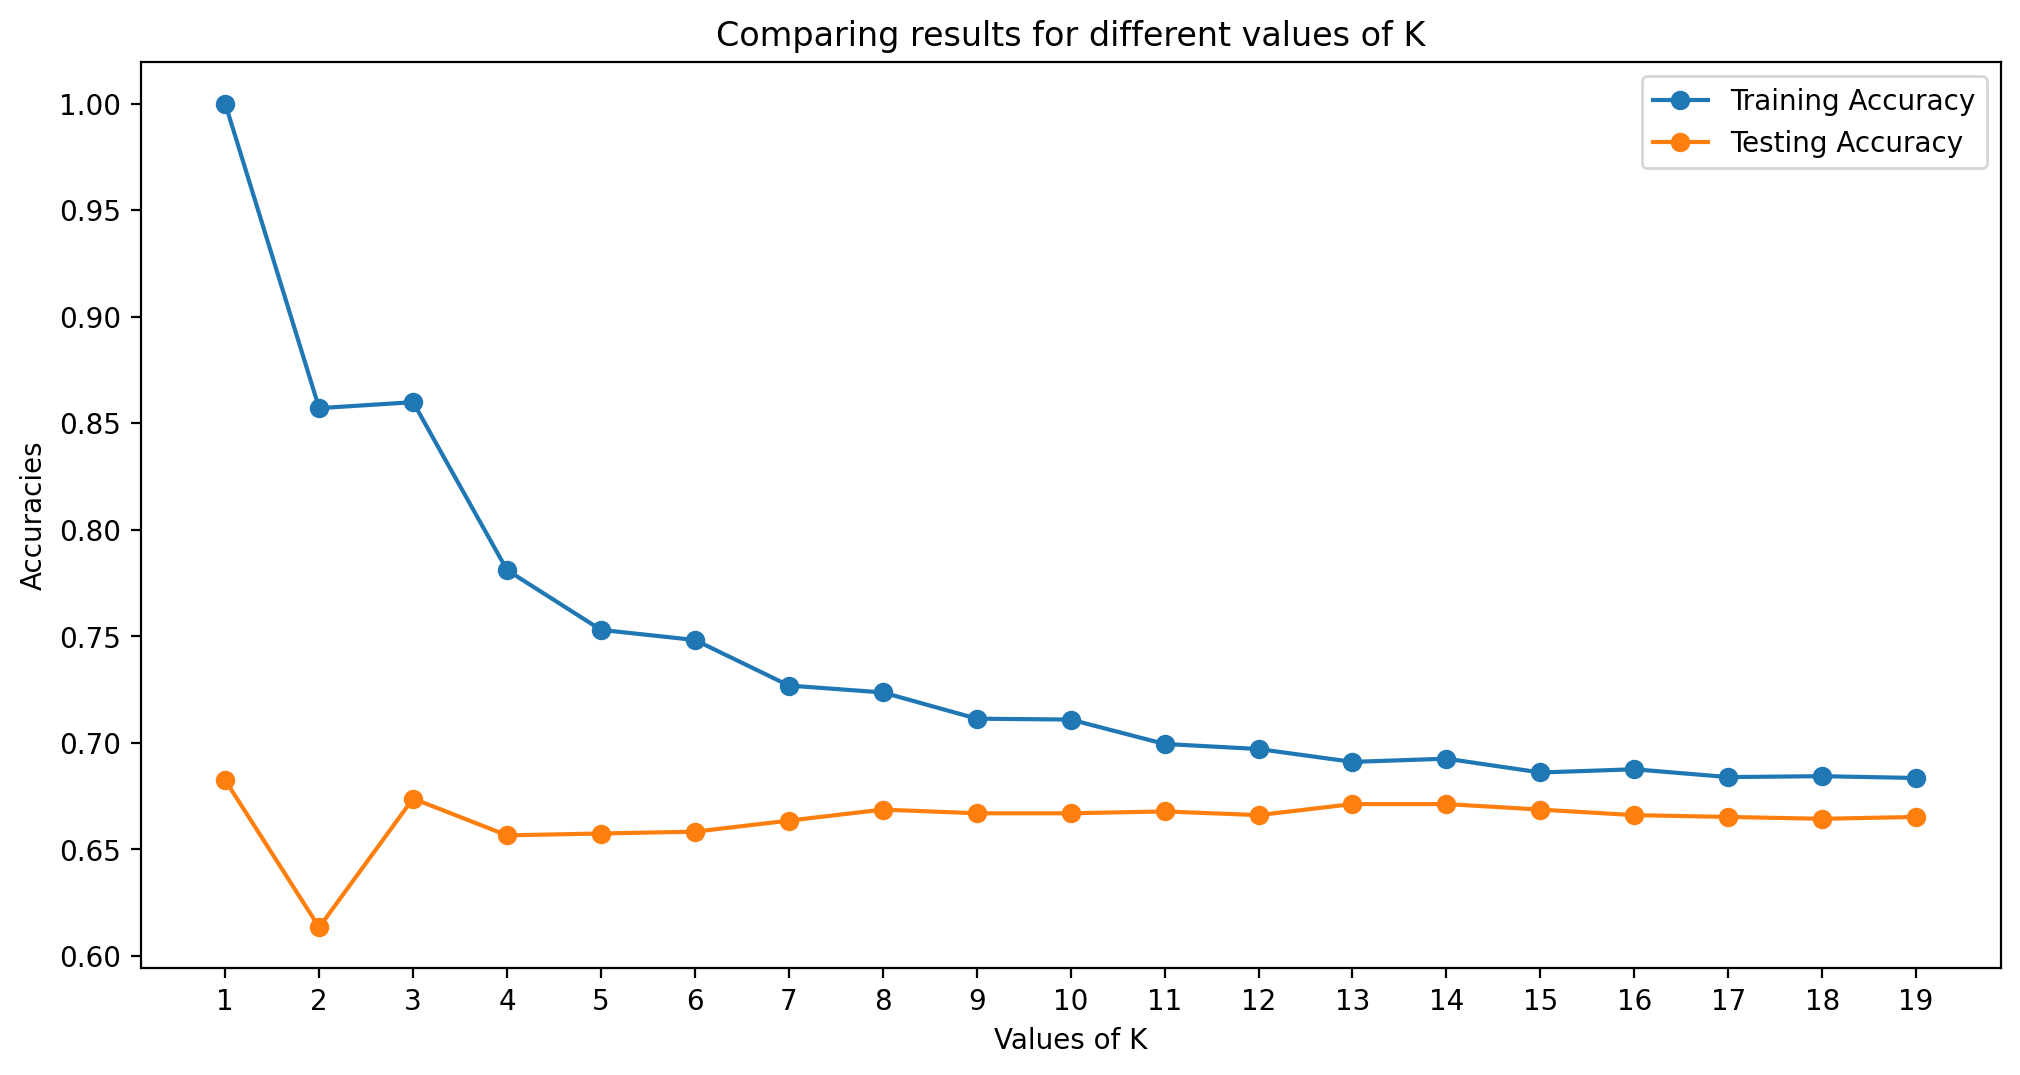

In [57]:
import matplotlib.pyplot as plt
x=list(range(1,20))
plt.figure(figsize=(12,6),dpi=200)
plt.plot(x,acc_train,'-o',label='Training Accuracy')
plt.plot(x,acc_test,'-o',label='Testing Accuracy')
plt.xticks(x)
plt.xlabel('Values of K')
plt.ylabel('Accuracies')
plt.title('Comparing results for different values of K')
plt.legend()

In [58]:
classifier=KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train,y_train)

y_pred_train=classifier.predict(X_train)
y_pred_test=classifier.predict(X_test)


print('Training accuracy',accuracy_score(y_train,y_pred_train))
print('Testing ACcuracy accuracy',accuracy_score(y_test,y_pred_test))

Training accuracy 0.6860967184801382
Testing ACcuracy accuracy 0.6686798964624676


#### Using Decision tree classifier for predicting sentiment 

In [59]:
from sklearn.tree import DecisionTreeClassifier
Classifier = DecisionTreeClassifier(criterion='entropy',max_depth=10)
Classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [60]:
y_pred_train=Classifier.predict(X_train)
y_pred_test=Classifier.predict(X_test)

In [61]:
print('Training accuracy',accuracy_score(y_train,y_pred_train))
print('Training accuracy',accuracy_score(y_test,y_pred_test))

Training accuracy 0.7346718480138169
Training accuracy 0.6988783433994823


#### Using RandomForest classifier for sentiment prediction

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10,max_depth=5,random_state=2)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)

In [63]:
pred_train = rf_classifier.predict(X_train)
pred_test = rf_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))


Training Accuracy :  0.6472366148531952
Testing  Accuracy :  0.6281276962899051


In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=200,max_depth=10,random_state=2)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=2)

In [65]:
pred_train = rf_classifier.predict(X_train)
pred_test = rf_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.6429188255613126
Testing  Accuracy :  0.6229508196721312


#### Using XGB classifier for predicting sentiment

In [66]:
from xgboost import XGBClassifier
xg_classifier=XGBClassifier(n_estimators=5)
xg_classifier.fit(X_train,y_train)

XGBClassifier(n_estimators=5)

In [67]:
pred_train = xg_classifier.predict(X_train)
pred_test = xg_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.7050949913644214
Testing  Accuracy :  0.6893874029335634


In [68]:
xg_classifier=XGBClassifier(n_estimators=10)
xg_classifier.fit(X_train,y_train)
pred_train = xg_classifier.predict(X_train)
pred_test = xg_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.7066062176165803
Testing  Accuracy :  0.6902502157031924


#### Using Adaboost classifier for prediciting sentiment

In [69]:
from sklearn.ensemble import AdaBoostClassifier
ad_classifier=AdaBoostClassifier(DecisionTreeClassifier(max_depth=6,max_features=50),n_estimators=20)
ad_classifier.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                         max_features=50),
                   n_estimators=20)

In [70]:
pred_train = ad_classifier.predict(X_train)
pred_test = ad_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.7294905008635578
Testing  Accuracy :  0.6557377049180327


In [71]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 90 kB/s 


#### Using CatBoost classifier for prediciting Sentiment

In [72]:
from catboost import CatBoostClassifier
cat_classifier=CatBoostClassifier(n_estimators=5)
cat_classifier.fit(X_train,y_train)

Learning rate set to 0.5
0:	learn: 0.6318929	total: 70.2ms	remaining: 281ms
1:	learn: 0.6165435	total: 104ms	remaining: 156ms
2:	learn: 0.5948458	total: 128ms	remaining: 85.1ms
3:	learn: 0.5796211	total: 150ms	remaining: 37.6ms
4:	learn: 0.5716029	total: 174ms	remaining: 0us


In [73]:
pred_train = cat_classifier.predict(X_train)
pred_test = cat_classifier.predict(X_test)

print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.7199913644214162
Testing  Accuracy :  0.7083692838654012


#### Using Voting Classifier for Sentiment prediction

In [74]:
from sklearn.ensemble import VotingClassifier
vt_classifier = VotingClassifier(estimators = [
                                ('rf', rf_classifier),
                                ('xg', xg_classifier),
                                ('ad', ad_classifier)], voting = 'hard')

vt_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=2)),
                             ('xg', XGBClassifier(n_estimators=10)),
                             ('ad',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                                                       max_features=50),
                                                 n_estimators=20))])

In [75]:
pred_train = vt_classifier.predict(X_train)
pred_test = vt_classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print('Training Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing  Accuracy : ', accuracy_score(y_test, pred_test))

Training Accuracy :  0.6971070811744386
Testing  Accuracy :  0.6738567730802416
